# Gensim word2vec for Wikipedia corpus

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import nltk

In [2]:
import os
cwd = os.getcwd()
cwd

'/Users/Salla/Dropbox (Aalto)/korp files/nlp-project/notebooks'

In [3]:
corpus = open("../output/wikipedia2008_fi_lemmatized.txt").read()

## Alternative cleaning:

Since Wiki data is already lemmatized, I will split the data at periods to get sentences and then split sentences at whitespace

Resulting data: list of lists 

In [4]:
# speeches is a list of list of sentences
sentences = re.split(r"[.!?]", corpus) 

# sentences as list of words
sents = [sent.strip().split() for sent in sentences if sent != ""]

In [5]:
sents[0:3]

[['redundanssi', 'olla', 'yli|määrä', ',', 'erityisesti', 'tieto', 'liittyä'],
 ['myös',
  'systeemi',
  'voida',
  'olla',
  'redundanssi',
  ',',
  'yli|määrä',
  'esimerkiksi',
  'vara|osa',
  'tai',
  'vaihto|ehtoisa',
  'toiminta|tapa',
  'tai',
  'rinnakkainen',
  'järjestelmä'],
 ['sotilaallisesti', 'reservi', 'olla', 'redundanssi']]

## Bigrams:

In [6]:
from gensim.models.phrases import Phrases, Phraser

Creates the relevant phrases from the list of sentences:

In [7]:
phrases = Phrases(sents, min_count=30, progress_per=10000)

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [8]:
bigram = Phraser(phrases)

Transform the corpus based on the bigrams detected:

In [9]:
sentences = bigram[sents]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [10]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

1119454

In [11]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

[',', 'olla', 'ja', ')', '(', 'hän', 'joka', 'se', '"', ':']

# Training the model
## Gensim Word2Vec Implementation:

In [12]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [13]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [14]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [15]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 1.74 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [16]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 51.6 mins


In [17]:
w2v_model.save("w2v_model.model.alt_preprocessing.wiki")

In [18]:
# Make model more memory-efficient
w2v_model.init_sims(replace=True)

# Exploring the model
## Most similar to:


In [19]:
w2v_model.wv.most_similar(positive=["keskusta"])

[('kaupunki_keskusta', 0.526954710483551),
 ('keskusta_sijaita', 0.5151245594024658),
 ('kaupunki', 0.5041964650154114),
 ('kunta|keskus', 0.5037741661071777),
 ('liike|keskusta', 0.49936243891716003),
 ('ydin|keskusta', 0.49562400579452515),
 ('kehä|tie', 0.493191123008728),
 ('ruutu|kaava|alue', 0.4924020767211914),
 ('keskusta|alue', 0.4923509359359741),
 ('alue', 0.48185357451438904)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [23]:
w2v_model.wv.most_similar(positive=["Matti_Vanhanen"])

[('Vanhanen', 0.6451828479766846),
 ('Anneli_Jäätteenmäki', 0.584527850151062),
 ('Jyrki_Katainen', 0.5670722723007202),
 ('Esko_Aho', 0.5612444877624512),
 ('Paavo_Lipponen', 0.5515259504318237),
 ('Paavo_Väyrynen', 0.5332513451576233),
 ('Ansipin', 0.5287086367607117),
 ('Jäätteenmäki', 0.5185158848762512),
 ('Sauli_Niinistö', 0.5183373689651489),
 ('kokoomus_puheen|johtaja', 0.5176243782043457)]

In [24]:
w2v_model.wv.most_similar(positive=["Paavo_Väyrynen"])

[('Anneli_Jäätteenmäki', 0.5612319111824036),
 ('Jyrki_Katainen', 0.5554324388504028),
 ('Esko_Aho', 0.5476837158203125),
 ('Matti_Vanhanen', 0.5332514047622681),
 ('Ilkka_Kanerva', 0.5325184464454651),
 ('Johannes_Virolainen', 0.514404833316803),
 ('Antti_kallio|mäki', 0.5140512585639954),
 ('kokoomus_puheen|johtaja', 0.5080595016479492),
 ('kansallinen_kokoomus', 0.5063538551330566),
 ('Riitta_Uosukainen', 0.5038676857948303)]

In [25]:
w2v_model.wv.most_similar(positive=["Timo_Soini"])

[('Heidi_Hautala', 0.6302870512008667),
 ('Ville_Itälä', 0.5929262638092041),
 ('Jyrki_Katainen', 0.5634692311286926),
 ('meri|kukka', 0.5517993569374084),
 ('Suvi-Anne_Siimes', 0.5475460290908813),
 ('perus|suomalainen', 0.5373443961143494),
 ('Sauli_Niinistö', 0.537105917930603),
 ('edus|kunta|vaali_2007', 0.5354493856430054),
 ('vihr', 0.5318007469177246),
 ('Kesk', 0.5245341658592224)]

## Similarities:

In [40]:
w2v_model.wv.similarity("keskusta", 'kokoomus')

0.37689748

In [41]:
w2v_model.wv.similarity("Matti_Vanhanen", "Paavo_Väyrynen")

0.5332514

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

In [30]:
w2v_model.wv.doesnt_match(["Paavo_Väyrynen", "Matti_Vanhanen", "Timo_Soini"])

/Users/Salla/anaconda3/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'Timo_Soini'

In [33]:
w2v_model.wv.doesnt_match(["Vasemmistoliitto"])

ValueError: cannot select a word from an empty list

## Analogy difference:

In [42]:
w2v_model.wv.most_similar(positive=["keskusta|puolue", "Jyrki_Katainen"], negative=["Matti_Vanhanen"], topn=3)

[('sosiaali|demokraatti', 0.451119065284729),
 ('puolue|hallitus', 0.44969600439071655),
 ('reformi|puolue', 0.437429279088974)]

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [44]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=21).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

## 10 Most similar words vs. 10 Most dissimilar


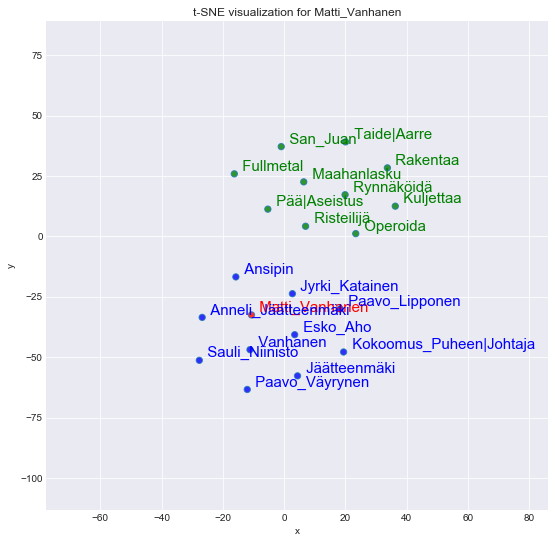

In [45]:
tsnescatterplot(w2v_model, 'Matti_Vanhanen', [i[0] for i in w2v_model.wv.most_similar(negative=["Matti_Vanhanen"])])

## 10 Most similar words vs. 11th to 20th Most similar words:


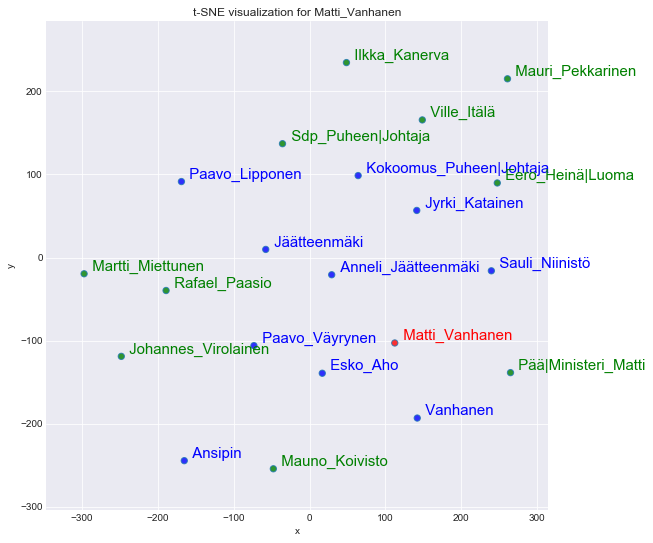

In [46]:
tsnescatterplot(w2v_model, "Matti_Vanhanen", [t[0] for t in w2v_model.wv.most_similar(positive=["Matti_Vanhanen"], topn=20)][10:])

